In [1]:
### Libs
import numpy as np
import pickle
import os
import itertools

def load_data(file):
   
    print('loading file: ' + file)
    with open(file, 'rb') as f:
        data = pickle.load(f)

    return(data)

def average_across_points(dat, window_size=10):
    dshape = dat['eeg'].shape
    new_length = dshape[-1] // window_size
    
    eeg_reshaped = dat['eeg'][:, :, :new_length * window_size].reshape(dshape[0], dshape[1], new_length, window_size)
    dat['eeg'] = eeg_reshaped.mean(axis=-1)
    dat['time'] = dat['time'][:new_length * window_size].reshape(new_length, window_size).mean(axis=-1)
    
    return dat

def upper(df):

    try:
        assert(type(df)==np.ndarray)
    except:
        if type(df)==pd.DataFrame:
            df = df.values
        else:
            raise TypeError('Must be np.ndarray or pd.DataFrame')
    mask = np.triu_indices(df.shape[0], k=1)
    return df[mask]

### Plotting settings
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import to_rgb

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rc('image', cmap='viridis')

plt.rcParams.update({
    "font.family": "serif",  
    # use serif/main font for text elements
    })
plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'font.weight': 'bold'})
plt.rcParams.update({'axes.linewidth': 2.5})
plt.rcParams.update({'axes.labelweight': 'bold'})
plt.rcParams.update({'axes.labelsize': 20})
plt.rc('legend',fontsize=12)

In [2]:
### Prep vars
sub = 2

eeg_data = load_data("/projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_epoched/eeg_things_{:04d}_{}.pickle".format(sub, "fix"))
eeg_data = average_across_points(eeg_data, window_size=10)
time = eeg_data["time"]
main_folder = "/projects/crunchie/boyanova/EEG_Things/eeg_experiment/"


loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_epoched/eeg_things_0002_fix.pickle


loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_decoding/eeg_decoding_0002.pickle
loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_decoding/eeg_decoding_0003.pickle
loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_decoding/eeg_decoding_0004.pickle
loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_decoding/eeg_decoding_0005.pickle
loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_decoding/eeg_decoding_0007.pickle
loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_decoding/eeg_decoding_0008.pickle
loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_decoding/eeg_decoding_0010.pickle
loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_decoding/eeg_decoding_0011.pickle
loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_decoding/eeg_decoding_0012.pickle
loading file: /projects/crunchie/boyanova/EEG_

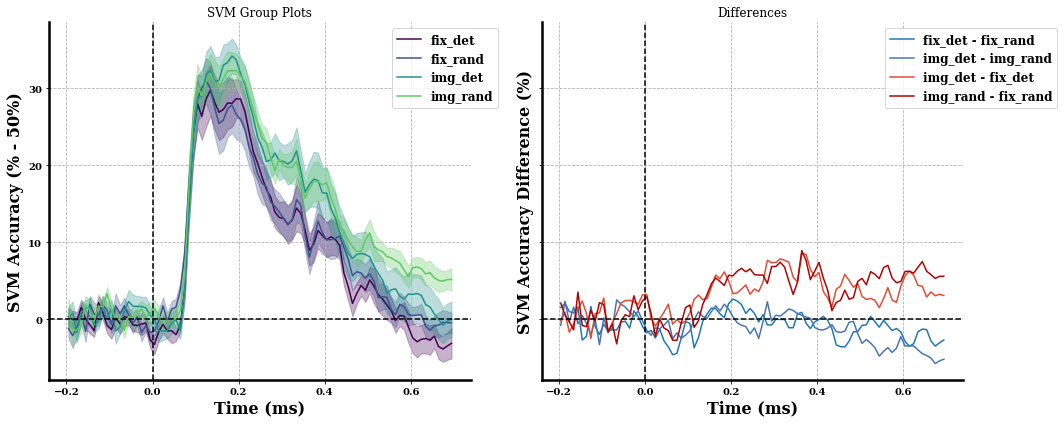

In [3]:
### SVM group plots
subjects = [2,3,4,5,7,8,10,11,12,13,14,15,16]
n_subjects = len(subjects)
subject_data = np.full((len(subjects), 4, len(time)), np.nan)

for sub_id, sub in enumerate(subjects):
    decoding_data = load_data(os.path.join(main_folder, f"eeg_decoding/eeg_decoding_{sub:04d}.pickle"))
    for key_id, key in enumerate(decoding_data.keys()):
        vec = []
        for t in range(decoding_data[key].shape[-1]):
            subject_data[sub_id, key_id, t] = (np.nanmean(decoding_data[key][:, :, t]) * 100) - 50

mean_data = np.mean(subject_data, axis=0)  # Shape: (4, 90)
sem_data = np.std(subject_data, axis=0, ddof=1) / np.sqrt(n_subjects) 
conditions = list(decoding_data.keys())

# Get all unique pairs of rows
#row_pairs = list(itertools.combinations(range(mean_data.shape[0]), 2))
row_pairs = [(0, 1), (2, 3), (2, 0), (3, 1)]
pairwise_differences = np.array([mean_data[i] - mean_data[j] for i, j in row_pairs])


from matplotlib.cm import viridis
condition_colors = [viridis(i / 4) for i in range(4)]
  

# Compute blended colors for pairwise differences
pair_colors = ["#1f77b4", "#4575b4", "#e34a33", "#b30000"] 

# Plot 1: Conditions
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharex = True, sharey = True)

for i in range(mean_data.shape[0]):  
    axes[0].plot(time, mean_data[i, :], label=conditions[i], color=condition_colors[i])
    axes[0].fill_between(
        time,
        mean_data[i, :] - sem_data[i, :],   
        mean_data[i, :] + sem_data[i, :],   
        color=condition_colors[i],
        alpha=0.3
    )

axes[0].grid(True, linestyle='--')
axes[0].legend(loc="upper left", bbox_to_anchor=(0.8, 1.0))
axes[0].axhline(y=0, color='k', linestyle='--')
axes[0].axvline(x=0.0, color='k', linestyle='--')
axes[0].set_xlabel("Time (ms)", fontsize=16)
axes[0].set_ylabel("SVM Accuracy (% - 50%)", fontsize=16)
axes[0].set_title("SVM Group Plots")

# Plot 2: Pairwise Differences
for i, color in enumerate(pair_colors):  
    axes[1].plot(time, pairwise_differences[i, :], color=color, label = f"{conditions[row_pairs[i][0]]} - {conditions[row_pairs[i][1]]}")

axes[1].grid(True, linestyle='--')
axes[1].axhline(y=0.0, color='k', linestyle='--')
axes[1].axvline(x=0.0, color='k', linestyle='--')
axes[1].set_xlabel("Time (ms)", fontsize=16)
axes[1].set_ylabel("SVM Accuracy Difference (%)", fontsize=16)
axes[1].set_title("Differences")
axes[1].legend(loc="upper left", bbox_to_anchor=(0.8, 1.0))

plt.tight_layout()
#plt.show()
plt.savefig(os.path.join(main_folder, f"results/Group_SVM_decoding.png"))

loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_decoding/eeg_mahlanobis_0002.pickle
loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_decoding/eeg_mahlanobis_0003.pickle
loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_decoding/eeg_mahlanobis_0004.pickle
loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_decoding/eeg_mahlanobis_0005.pickle
loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_decoding/eeg_mahlanobis_0007.pickle
loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_decoding/eeg_mahlanobis_0008.pickle
loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_decoding/eeg_mahlanobis_0010.pickle
loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_decoding/eeg_mahlanobis_0011.pickle
loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_decoding/eeg_mahlanobis_0012.pickle
loading file: /projects/crun

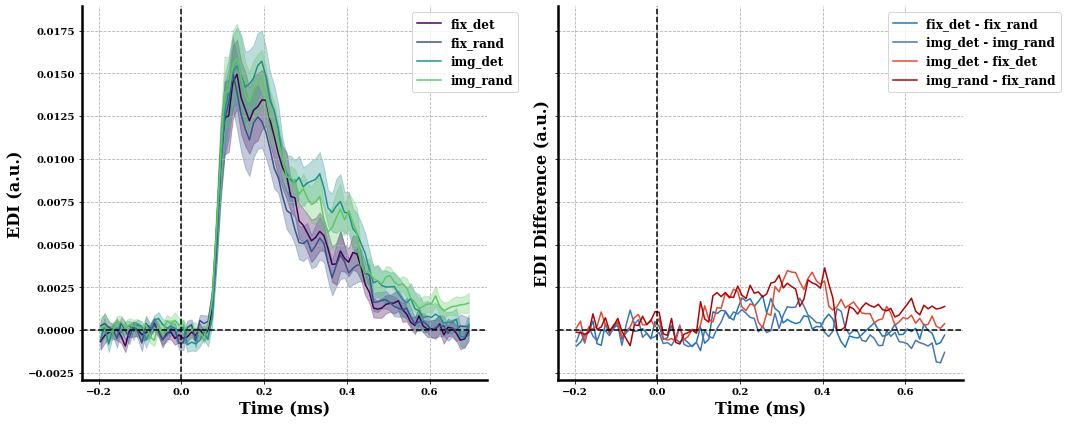

In [6]:
subjects = [2,3,4,5,7,8,10,11,12,13,14,15,16]
n_subjects = len(subjects)
subject_data = np.full((len(subjects), 4, len(time)), np.nan)

for sub_id, sub in enumerate(subjects):
    edi_data = load_data(os.path.join(main_folder, f"eeg_decoding/eeg_mahlanobis_{sub:04d}.pickle"))
    for key_id, key in enumerate(edi_data.keys()):
        vec = []
        for t in range(edi_data[key].shape[-1]):
            subject_data[sub_id, key_id, t] = np.mean(upper(edi_data[key][:, :, t])) - np.mean(np.diagonal(edi_data[key][:, :, t]))

# Step 1: Compute the mean and standard deviation across subjects (axis=0)
mean_data = np.mean(subject_data, axis=0)  # Shape: (4, 90)
sem_data = np.std(subject_data, axis=0, ddof=1) / np.sqrt(n_subjects)
row_pairs = [(0, 1), (2, 3), (2, 0), (3, 1)]
pairwise_differences = np.array([mean_data[i] - mean_data[j] for i, j in row_pairs])

conditions = list(edi_data.keys())
condition_colors = [viridis(i / 4) for i in range(4)]
  

# Compute blended colors for pairwise differences
pair_colors = ["#1f77b4", "#4575b4", "#e34a33", "#b30000"] 

# Plot 1: Conditions
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharex = True, sharey = True)

for i in range(mean_data.shape[0]):  
    axes[0].plot(time, mean_data[i, :], label=conditions[i], color=condition_colors[i])
    axes[0].fill_between(
        time,
        mean_data[i, :] - sem_data[i, :],   
        mean_data[i, :] + sem_data[i, :],   
        color=condition_colors[i],
        alpha=0.3
    )

axes[0].grid(True, linestyle='--')
axes[0].legend(loc="upper left", bbox_to_anchor=(0.8, 1.0))
axes[0].axhline(y=0, color='k', linestyle='--')
axes[0].axvline(x=0.0, color='k', linestyle='--')
axes[0].set_xlabel("Time (ms)", fontsize=16)
axes[0].set_ylabel("EDI (a.u.)", fontsize=16)


# Plot 2: Pairwise Differences
for i, color in enumerate(pair_colors):  
    axes[1].plot(time, pairwise_differences[i, :], color=color, label = f"{conditions[row_pairs[i][0]]} - {conditions[row_pairs[i][1]]}")

axes[1].grid(True, linestyle='--')
axes[1].axhline(y=0.0, color='k', linestyle='--')
axes[1].axvline(x=0.0, color='k', linestyle='--')
axes[1].set_xlabel("Time (ms)", fontsize=16)
axes[1].set_ylabel("EDI Difference (a.u.)", fontsize=16)
axes[1].legend(loc="upper left", bbox_to_anchor=(0.8, 1.0))

plt.tight_layout()
#plt.show()
plt.savefig(os.path.join(main_folder, f"results/Group_EDI.png"))

### Check sequence data

loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_decoding/eeg_svm_sequences_combined_0000.pickle
loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_decoding/eeg_svm_sequences_combined_0001.pickle


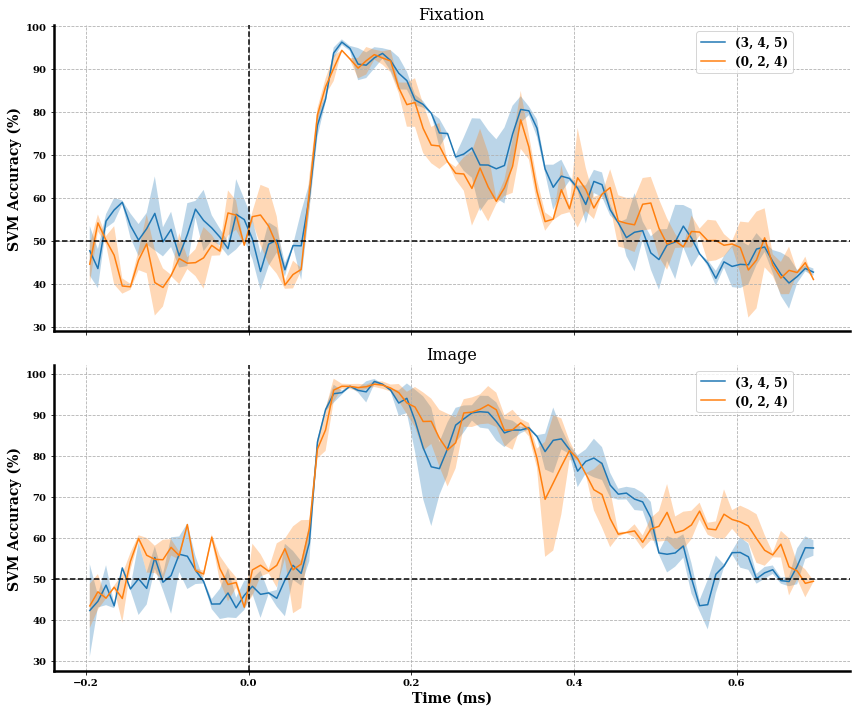

In [8]:
### SVM group plots
subjects = [0,1]
subject_data = np.full((len(subjects),2, 4, len(time)), np.nan)

for sub_id, sub in enumerate(subjects):
    decoding_data = load_data(os.path.join(main_folder, f"eeg_decoding/eeg_svm_sequences_combined_{sub:04d}.pickle"))
    for key_id, key in enumerate(decoding_data.keys()):
        for seq_id, seq in enumerate(decoding_data[key].keys()):
            vec = []
            for t in range(decoding_data[key][seq].shape[-1]):
                subject_data[sub_id, key_id, seq_id, t] = np.nanmean(decoding_data[key][seq][:, :, t]) * 100

            
mean_data = np.mean(subject_data, axis=0)  # Shape: (2, 4, 90)
std_data = np.std(subject_data, axis=0)    # Shape: (2, 4, 90)
conditions = list(decoding_data[key].keys())[1:-1]

# Create a figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot the first set of data ("Fixation") on the first subplot
axes[0].set_title("Fixation", fontsize=16)
for i in range(len(conditions)):  
    axes[0].plot(time, mean_data[0, i, :], label=conditions[i])
    axes[0].fill_between(
        time,
        mean_data[0, i, :] - std_data[0, i, :],
        mean_data[0, i, :] + std_data[0, i, :],
        alpha=0.3
    )
axes[0].grid(True, linestyle='--')
axes[0].legend(loc="upper left", bbox_to_anchor=(0.8, 1.0))
axes[0].axhline(y=50, color='k', linestyle='--')
axes[0].axvline(x=0.0, color='k', linestyle='--')
axes[0].set_ylabel("SVM Accuracy (%)", fontsize=14)

# Plot the second set of data ("Image") on the second subplot
axes[1].set_title("Image", fontsize=16)
for i in range(len(conditions)):  
    axes[1].plot(time, mean_data[1, i, :], label=conditions[i])
    axes[1].fill_between(
        time,
        mean_data[1, i, :] - std_data[1, i, :],
        mean_data[1, i, :] + std_data[1, i, :],
        alpha=0.3
    )
axes[1].grid(True, linestyle='--')
axes[1].legend(loc="upper left", bbox_to_anchor=(0.8, 1.0))
axes[1].axhline(y=50, color='k', linestyle='--')
axes[1].axvline(x=0.0, color='k', linestyle='--')
axes[1].set_xlabel("Time (ms)", fontsize=14)
axes[1].set_ylabel("SVM Accuracy (%)", fontsize=14)

# Adjust layout
plt.tight_layout()
plt.show()

loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_decoding/eeg_mahlanobis_sequences_combined_0000.pickle
loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_decoding/eeg_mahlanobis_sequences_combined_0001.pickle


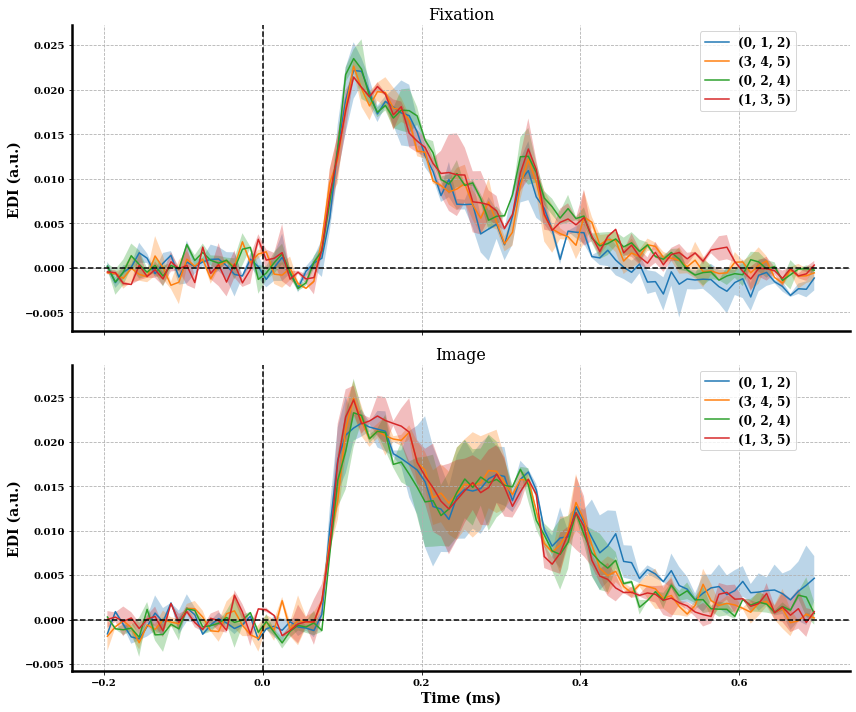

In [21]:
subjects = [0,1]
subject_data = np.full((len(subjects),2, 4, len(time)), np.nan)

for sub_id, sub in enumerate(subjects):
    edi_data = load_data(os.path.join(main_folder, f"eeg_decoding/eeg_mahlanobis_sequences_combined_{sub:04d}.pickle"))
    for key_id, key in enumerate(edi_data.keys()):
        for seq_id, seq in enumerate(edi_data[key].keys()):
            vec = []
            for t in range(edi_data[key][seq].shape[-1]):
                subject_data[sub_id, key_id, seq_id, t] = np.mean(upper(edi_data[key][seq][:, :, t])) - np.mean(np.diagonal(edi_data[key][seq][:, :, t]))

# Step 1: Compute the mean and standard deviation across subjects (axis=0)
mean_data = np.mean(subject_data, axis=0)  # Shape: (4, 90)
std_data = np.std(subject_data, axis=0) 
conditions = list(edi_data[key].keys())

# Create a figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot the first set of data ("Fixation") on the first subplot
axes[0].set_title("Fixation", fontsize=16)
for i in range(mean_data.shape[1]):  
    axes[0].plot(time, mean_data[0, i, :], label=conditions[i])
    axes[0].fill_between(
        time,
        mean_data[0, i, :] - std_data[0, i, :],
        mean_data[0, i, :] + std_data[0, i, :],
        alpha=0.3
    )
axes[0].grid(True, linestyle='--')
axes[0].legend(loc="upper left", bbox_to_anchor=(0.8, 1.0))
axes[0].axhline(y=0.0, color='k', linestyle='--')
axes[0].axvline(x=0.0, color='k', linestyle='--')
axes[0].set_ylabel("EDI (a.u.)", fontsize=14)

# Plot the second set of data ("Image") on the second subplot
axes[1].set_title("Image", fontsize=16)
for i in range(mean_data.shape[1]):  
    axes[1].plot(time, mean_data[1, i, :], label=conditions[i])
    axes[1].fill_between(
        time,
        mean_data[1, i, :] - std_data[1, i, :],
        mean_data[1, i, :] + std_data[1, i, :],
        alpha=0.3
    )
axes[1].grid(True, linestyle='--')
axes[1].legend(loc="upper left", bbox_to_anchor=(0.8, 1.0))
axes[1].axhline(y=0.0, color='k', linestyle='--')
axes[1].axvline(x=0.0, color='k', linestyle='--')
axes[1].set_xlabel("Time (ms)", fontsize=14)
axes[1].set_ylabel("EDI (a.u.)", fontsize=14)

# Adjust layout
plt.tight_layout()
plt.show()